# Data Exploration Project - Pumps

## Business Understanding

Daten über verschiedene Brunnen in einem afrikanischen Land.

**Können wir vorhersagen welche Brunnen defekt, wartungsbedürftig oder voll funktional sind?**

## Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

Einlesen der Trainings- und Testdaten.

In [2]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Data Analysis

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [3]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [4]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [5]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [6]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [7]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    # ("ord_enc", OrdinalEncoder()),
    ("scale", MinMaxScaler())
])

In [8]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [9]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add new feature manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
y_train_r = df_train["t_needs_rep"]

col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [10]:
X_train = col_trans.fit_transform(X=df_train, y=y_train)

C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\ti-he\AppData\Roaming\Python\Python37\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


## Modeling

ToDo: Test with different Preparation-Pipelines

### a. Model Selection

In [11]:
df_results = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

#### LogisticRegression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

lr_cf = LogisticRegression(multi_class="ovr", max_iter=1000)
lr_cf.fit(X_train, y_train)
y_pred = lr_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=lr_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

In [13]:
df_results.loc[len(df_results)] = [lr_cf, auc_train, auc_cv]

#### SVM

In [14]:
from sklearn.svm import SVC

svm_cf = SVC(probability=True, decision_function_shape="ovr")
svm_cf.fit(X_train, y_train)
y_pred = svm_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=svm_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv]
df_results.loc[len(df_results)] = ["SVC", 0, 0]

#### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn_cf = KNeighborsClassifier()
knn_cf.fit(X_train, y_train)
y_pred = knn_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=knn_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [knn_cf, auc_train, auc_cv]

#### Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt_cf = DecisionTreeClassifier()
dt_cf.fit(X_train, y_train)
y_pred = dt_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=dt_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [dt_cf, auc_train, auc_cv]

#### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train, y_train)
y_pred = rf_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [str(rf_cf), auc_train, auc_cv]

#### XGBoost

In [18]:
from xgboost import XGBClassifier

xgb_cf = XGBClassifier()
xgb_cf.fit(X_train, y_train)
y_pred = xgb_cf.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv]

In [19]:
# df_results.to_csv("pm3_sel_results.csv")
df_results

,Model,AUC Train,AUC CV
0,"LogisticRegression(max_iter=1000, multi_class=...",0.869001,0.866267
1,SVC(probability=True),0.912153,0.893115
2,SVC,0.000000,0.000000
3,KNeighborsClassifier(),0.957829,0.855479
4,DecisionTreeClassifier(),1.000000,0.750551
5,RandomForestClassifier(random_state=42),1.000000,0.902239
6,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.964362,0.925640


<AxesSubplot:>

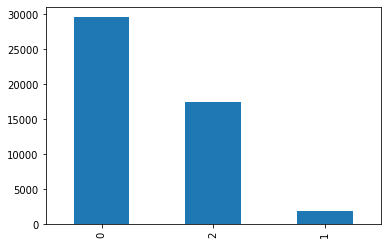

In [20]:
pd.Series(xgb_cf.predict(X_train)).value_counts().plot.bar()

### b. Hyperparameter Tuning

Gewählte Modelle:
- RandomForest
- XGBoost \
--> Bester CV-Score, trotzdem noch Overfitting, viele Hyperparameter zum Anpassen --> Ideal für Hyperparameter Tuning

In [21]:
df_tuned = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

#### Random Forest

In [22]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rf_cf = RandomForestClassifier(random_state=42)

model_params = {
    'n_estimators': np.linspace(10,500,50,dtype=int),
    'max_depth': np.linspace(2,30,15,dtype=int),
}

rs = RandomizedSearchCV(rf_cf, model_params, n_iter=20, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_

{'n_estimators': 400, 'max_depth': 16}

In [23]:
param_grid = [{
    "n_estimators":[300, 350, 400],
    "max_depth": [16, 18, 20],
    #"bootstrap": [True, False]
}]

rf_cf_opt = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf_cf_opt, param_grid=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9159432168280753
{'max_depth': 18, 'n_estimators': 400}


In [24]:
display(pd.DataFrame(gs.cv_results_)[["param_max_depth", "param_n_estimators", "mean_test_score", "rank_test_score"]])

,param_max_depth,param_n_estimators,mean_test_score,rank_test_score
0,16,300,0.915558,6
1,16,350,0.915649,5
2,16,400,0.915800,3
3,18,300,0.915744,4
4,18,350,0.915837,2
5,18,400,0.915943,1
6,20,300,0.914980,9
7,20,350,0.915065,8
8,20,400,0.915187,7


In [25]:
rf_cf_opt = gs.best_estimator_

rf_cf_opt.fit(X_train, y_train)
y_pred = rf_cf_opt.predict_proba(X_train)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf_opt, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [str(rf_cf_opt), auc_train, auc_cv]

#### XGBoost

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb_cf = XGBClassifier()

model_params = {
    'n_estimators': np.linspace(10,400,50,dtype=int),
    'max_depth': np.linspace(2,30,15,dtype=int),
    'learning_rate': np.linspace(0.1,1,10)
}

rs = RandomizedSearchCV(xgb_cf, model_params, n_iter=15, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_

{'n_estimators': 49, 'max_depth': 8, 'learning_rate': 0.4}

In [31]:
param_grid = [{
    "n_estimators":[25, 50, 100],
    "max_depth": [6, 8, 10],
    "learning_rate": [0.1, 0.5]
}]

xgb_cf = XGBClassifier()
gs = GridSearchCV(xgb_cf, param_grid=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_params_

{'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 100}

In [32]:
xgb_cf_opt = gs.best_estimator_

xgb_cf_opt.fit(X_train, y_train)
y_pred = xgb_cf_opt.predict_proba(X_train)

auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf_opt, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [str(xgb_cf_opt), auc_train, auc_cv]

In [33]:
# df_tuned.to_csv("pm3_tuned.csv")
df_tuned

,Model,AUC Train,AUC CV
0,"RandomForestClassifier(max_depth=18, n_estimat...",0.992316,0.915943
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.987123,0.925518
2,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.976437,0.924926


### c. Dimensionality Reduction

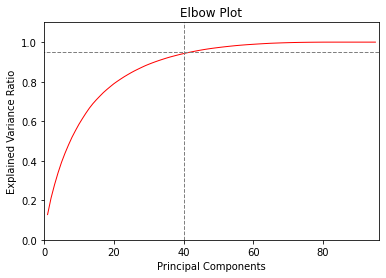

In [ ]:
from sklearn.decomposition import PCA

pca_pl = PCA(n_components=len(X_train.T))
pca_pl.fit(X_train)


plt.plot(np.arange(pca_pl.n_components_) + 1, np.cumsum(pca_pl.explained_variance_ratio_), linewidth=1, color='red')
plt.title('Elbow Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.hlines(0.95, -1, 100, linestyle="--", linewidth=1, color="grey")
plt.vlines(40, 0, 1.1, linestyle="--", linewidth=1, color="grey")
plt.xlim(0,96)
plt.ylim(0,1.1)
plt.show()


In [ ]:
pca = PCA(n_components=40)
pca.fit(X_train)
X_train_ = pca.transform(X_train)

In [ ]:
rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train_, y_train)
y_pred = rf_cf.predict_proba(X_train_)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf, X=X_train_, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
print(f"{auc_train}, {auc_cv}")

0.9999999994262022, 0.8755975571410126


In [ ]:
from xgboost import XGBClassifier

xgb_cf = XGBClassifier()
xgb_cf.fit(X_train_, y_train)
y_pred = xgb_cf.predict_proba(X_train_)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train_, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
print(f"{auc_train}, {auc_cv}")

0.9691582243378876, 0.9040651574737595


#### d. Treating Imbalances

In [ ]:
from sklearn.utils import class_weight
classes_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))

weights = np.ones(y_train.shape[0], dtype='float')

for i, val in enumerate(y_train):
    weights[i] = classes_weights[val-1]

xgb_cf_w = XGBClassifier()
xgb_cf_w.fit(X_train, y_train, sample_weight=weights);

In [ ]:
y_pred = xgb_cf_w.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf_w, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
print(f"{auc_train}, {auc_cv}")

0.9594796427886951, 0.9256401412787248


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, xgb_cf_w.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.72      0.82     26698
           1       0.88      0.22      0.36      3356
           2       0.68      0.98      0.80     18904

    accuracy                           0.79     48958
   macro avg       0.83      0.64      0.66     48958
weighted avg       0.83      0.79      0.78     48958



In [ ]:
rf_cf_w = RandomForestClassifier(random_state=42)
rf_cf_w.fit(X_train, y_train, sample_weight=weights)
y_pred = rf_cf_w.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
cv_res = cross_validate(estimator=rf_cf_w, X=X_train, y=y_train, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
print(f"{auc_train}, {auc_cv}")

0.9999999997066454, 0.9022388708551381


## Evaluation

With unseen test data (out-of-sample validation)

In [34]:
df_pump_test = pd.read_csv("pump_test.csv")

df_test = df_pump_test.copy()

df_test["t_functional"] = df_test["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_test["t_needs_rep"] = df_test["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

df_test = df_test.drop(df_test[df_test.longitude == 0].index)

df_test["amount_per_capita"] = df_test.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)

df_test["district_code"] = df_test["district_code"].astype("category")
df_test["region_code"] = df_test["region_code"].astype("category")

y_test = df_test.loc[:,'status_group']
y_test = le.transform(y_test)

y_test_f = df_test["t_functional"]
y_test_r = df_test["t_needs_rep"]

In [35]:
X_test = col_trans.transform(X=df_test)

In [36]:
auc_test_rf = roc_auc_score(y_test, rf_cf_opt.predict_proba(X_test), multi_class='ovr')
auc_test_xgb = roc_auc_score(y_test, xgb_cf_opt.predict_proba(X_test), multi_class='ovr')

In [39]:
df_tuned["AUC Test"] = [auc_test_rf, np.nan, auc_test_xgb]
df_tuned

,Model,AUC Train,AUC CV,AUC Test
0,"RandomForestClassifier(max_depth=18, n_estimat...",0.992316,0.915943,0.898758
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.987123,0.925518,NaN
2,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.976437,0.924926,0.859576


In [40]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_AUC(model, X_train, y_train, X_test, y_test):

    vis = ROCAUC(model, encoder={0: 'functional', 1: ' func_needs_rep', 2: 'non_functional'})
                                                                         
    vis.fit(X_train, y_train)
    vis.score(X_test, y_test)
    vis.show()
    
    return vis

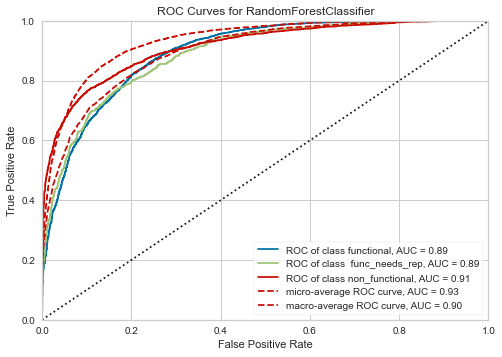

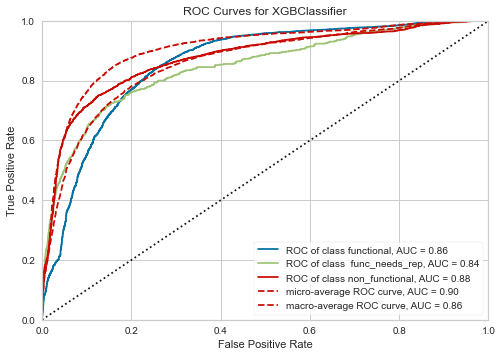

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'functional', 1: ' func_needs_rep', 2: 'non_functional'},
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_ca...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.5, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree

In [42]:
plot_ROC_AUC(rf_cf_opt, X_train, y_train, X_test, y_test)
plot_ROC_AUC(xgb_cf_opt, X_train, y_train, X_test, y_test)